In [121]:
'ADC to FFT carrier seat new approach'


'ADC to FFT carrier seat new approach'

# Loading the data

In [122]:
import gc
gc.collect()

0

In [123]:
%reset -f

In [124]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [125]:
# Set directory containing CSV files
data_dir = r"/Users/mandarkale/Documents/MyProjects/MachineLearning/Raw/Carrierseat/"

# Load all CSV files
csv_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.csv')]
dfs = [pd.read_csv(file, header=None) for file in csv_files]


In [126]:
# Combine all CSV data
combined_df = pd.concat(dfs, ignore_index=True)
combined_df

,0,1,2,3,4,5,6,7,8,9,...,16390,16391,16392,16393,16394,16395,16396,16397,16398,16399
0,64,32768,1,1,512,0,1953125,12,0.0,0,...,-14,-14,-17,-12,-8,-5,-2,0,1,-1
1,64,32768,1,1,512,0,1953125,12,0.0,0,...,19,25,28,32,35,36,44,47,47,48
2,64,32768,1,1,512,0,1953125,12,0.0,0,...,-16,-11,-10,-8,-7,-3,4,4,5,8
3,64,32768,1,1,512,0,1953125,12,0.0,0,...,-9,-12,-15,-13,-10,-9,-6,-1,3,9
4,64,32768,1,1,512,0,1953125,12,0.0,0,...,32,29,26,20,13,15,11,9,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,64,32768,2,1,512,0,1953125,12,0.0,0,...,-6,-9,-10,-5,-2,1,7,9,12,14
24996,64,32768,2,1,512,0,1953125,12,0.0,0,...,10,9,11,5,0,0,-2,-2,-1,-2
24997,64,32768,2,1,512,0,1953125,12,0.0,0,...,29,27,26,25,24,21,21,21,16,17
24998,64,32768,2,1,512,0,1953125,12,0.0,0,...,99,97,96,96,96,103,104,98,98,98


In [127]:
combined_df.shape

(25000, 16400)

In [128]:
#remove headers
raw_data = combined_df.iloc[:, 16:]
raw_data

,16,17,18,19,20,21,22,23,24,25,...,16390,16391,16392,16393,16394,16395,16396,16397,16398,16399
0,-4,5,11,-193,-163,-131,-106,-82,-77,-64,...,-14,-14,-17,-12,-8,-5,-2,0,1,-1
1,48,50,52,71,81,93,109,120,126,123,...,19,25,28,32,35,36,44,47,47,48
2,11,15,22,-111,-94,-88,-71,-44,-13,18,...,-16,-11,-10,-8,-7,-3,4,4,5,8
3,14,23,27,30,-225,-242,-254,-260,-263,-264,...,-9,-12,-15,-13,-10,-9,-6,-1,3,9
4,-7,-7,-6,61,25,-12,-46,-88,-127,-162,...,32,29,26,20,13,15,11,9,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,11,12,11,193,114,29,-59,-145,-225,-299,...,-6,-9,-10,-5,-2,1,7,9,12,14
24996,-9,-7,-8,-8,-7,-7,202,289,345,400,...,10,9,11,5,0,0,-2,-2,-1,-2
24997,16,16,12,-69,4,78,153,229,307,382,...,29,27,26,25,24,21,21,21,16,17
24998,97,96,96,288,325,358,386,397,401,392,...,99,97,96,96,96,103,104,98,98,98


In [129]:
adc_data = raw_data.values  # Extract ADC values (skip metadata columns)
adc_data
#print(f"Loaded data shape: {adc_data.shape}")  # Shape should be (num_samples, num_features)


array([[ -4,   5,  11, ...,   0,   1,  -1],
       [ 48,  50,  52, ...,  47,  47,  48],
       [ 11,  15,  22, ...,   4,   5,   8],
       ...,
       [ 16,  16,  12, ...,  21,  16,  17],
       [ 97,  96,  96, ...,  98,  98,  98],
       [-63, -59, -57, ..., -63, -65, -63]], shape=(25000, 16384))

In [130]:
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(signal, cutoff=30e3, fs=1e6, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

filtered_data = np.array([butter_lowpass_filter(row) for row in adc_data])
filtered_data

array([[ -4.5670524 ,  -7.92318243, -11.01793639, ...,  -7.65074749,
         -7.43849739,  -7.1902199 ],
       [ 36.28973132,  43.93233558,  51.92547243, ...,  41.08674143,
         43.13049157,  44.93091959],
       [ 10.58950131,  11.96069956,  13.46825154, ...,  -2.01595356,
         -0.8537062 ,   0.23143414],
       ...,
       [ 15.33951341,  66.95579035, 119.04798415, ...,  20.95613152,
         19.96234729,  19.07890513],
       [130.88921453, 160.75819823, 189.04990821, ...,  96.50440953,
         96.13782184,  95.84180235],
       [-33.00662259,  -2.57212144,  25.68612356, ..., -66.69882042,
        -66.65583982, -66.58070412]], shape=(25000, 16384))

In [131]:
def calculate_snr(signal, noise):
    power_signal = np.mean(signal ** 2)
    power_noise = np.mean(noise ** 2)
    return 10 * np.log10(power_signal / power_noise)

snr_after = calculate_snr(filtered_data, adc_data - filtered_data)
print(f"SNR After Fixing: {snr_after:.2f} dB")

SNR After Fixing: 26.80 dB


In [132]:
# Select from the 17th column to the end
adc_data_selected_columns = filtered_data.mean(axis=1)  # Python uses 0-based indexing
adc_data_selected_columns

array([ 13.73580828,  -6.96431297,   8.18443033, ...,  51.76344868,
       -44.09127919,   3.11944492], shape=(25000,))

# ADC to FFT Conversion

In [133]:
# Assuming `adc_data` is your pandas Series with ADC data
adc_array = adc_data_selected_columns # Convert the pandas Series to a numpy array

# Choose a window function - Hanning window in this case
window = np.hanning(len(adc_array))

# Apply the window function to your data
windowed_adc_data = adc_array * window

# Perform FFT on the windowed data
fft_result = np.fft.fft(windowed_adc_data)

# Frequency bins (assuming you know the sampling rate)
sampling_rate = 1953125  # Example: 1000 Hz, replace with your actual sampling rate
min_freq = 35000  # 35 kHz
max_freq = 45000  # 45 kHz

n = len(adc_array)
freq = np.fft.fftfreq(n, d=1/sampling_rate)
# Calculate the magnitude and phase of the FFT result
magnitude = np.abs(fft_result)
phase = np.angle(fft_result)

# Filter frequencies within 35kHz - 45kHz
#valid_indices = (freq >= min_freq) & (freq <= max_freq)
#filtered_freqs = freq[valid_indices]
#filtered_magnitudes = magnitude[valid_indices]
#filtered_phase = phase[valid_indices]

# Create a DataFrame
fft_df = pd.DataFrame({
    'Frequency': freq,
    'FFT Magnitude': magnitude,
    'Phase': phase
})


fft_df.head()  # Display the first few rows of the DataFrame

,Frequency,FFT Magnitude,Phase
0,0.000,104749.366658,0.000000
1,78.125,52421.282760,-3.130457
2,156.250,2858.080997,1.630063
3,234.375,2785.146203,-0.997409
4,312.500,1836.985949,2.804369


In [134]:
# Add a new column to the fft_magnitude DataFrame for the binary label
# Set the value to 1 for presence of an infant with a carriage
#For Empty vs carrier
fft_df['Object_Presence'] = 1 # 1 for presence, 0 for absence 
#For Withbaby vs Withoutbaby
#fft_df['Infant_Presence'] = 1 # 1 for presence, 0 for absence 
# Display the first few rows to verify the new column
fft_df.head()

,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.000,104749.366658,0.000000,1
1,78.125,52421.282760,-3.130457,1
2,156.250,2858.080997,1.630063,1
3,234.375,2785.146203,-0.997409,1
4,312.500,1836.985949,2.804369,1


In [135]:
len(fft_df)

25000

In [136]:
fft_df.tail()

,Frequency,FFT Magnitude,Phase,Object_Presence
24995,-390.625,2292.262638,1.045935,1
24996,-312.500,1836.985949,-2.804369,1
24997,-234.375,2785.146203,0.997409,1
24998,-156.250,2858.080997,-1.630063,1
24999,-78.125,52421.282760,3.130457,1


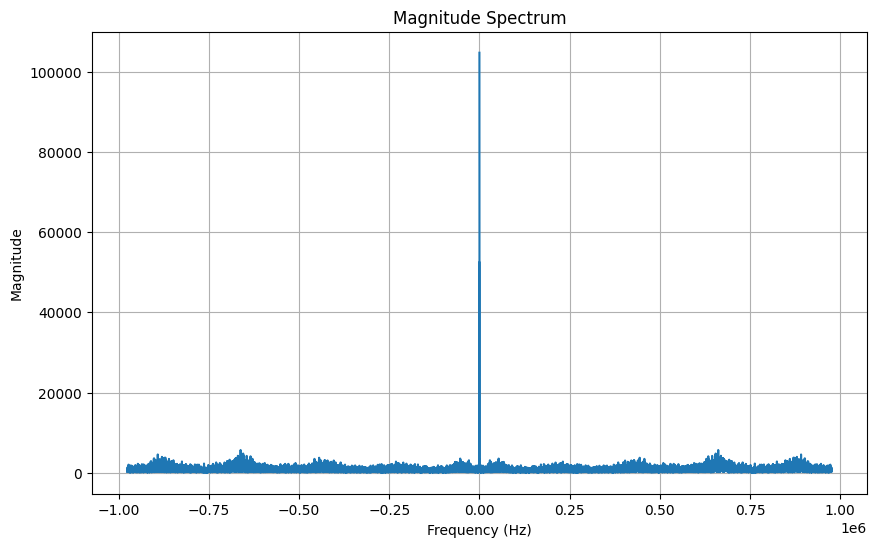

In [137]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(fft_df['Frequency'], fft_df['FFT Magnitude'])  # Plot positive frequency vs magnitude
plt.title('Magnitude Spectrum')  # Title of the plot
plt.xlabel('Frequency (Hz)')  # Label for the x-axis
plt.ylabel('Magnitude')  # Label for the y-axis
plt.grid(True)  # Show grid for better readability
plt.show()  # Display the plot

#  Saving to nump array

In [138]:
numpy_array = fft_df.to_numpy()
# Save the array to a file
#np.save('demo_3.npy', numpy_array)

# Define save path (2 levels up → Data/Processed/)
save_path = os.path.join("..", "..", "Data", "Processed", 
                         "CarrierSeat_withoutBaby_Lowpassfilered_Label_0.npy")

# If file already exists, remove it
if os.path.exists(save_path):
    os.remove(save_path)
    print(f"Old file removed: {save_path}")

# Save the array to that location
np.save(save_path, numpy_array)

print(f"New file saved at: {os.path.abspath(save_path)}")

Old file removed: ../../Data/Processed/CarrierSeat_withoutBaby_Lowpassfilered_Label_0.npy
New file saved at: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Data/Processed/CarrierSeat_withoutBaby_Lowpassfilered_Label_0.npy


In [139]:
import gc
gc.collect()

3485

In [140]:
%reset -f